# Perspectives

To finish this section of the basics of the problem domain, we can take 
a brief look at some high-level aspects of the baseline signal processing-based approach for beat estimation, 
and constrast this with the potential, and arguably, the naïve expectation of a deep learning approach.

In the example below we can see:
* The input audio waveform of our go-to easy example with the annotated beat locations
* The mel spectrogram time-frequency representation 
* The spectral flux function derived from the mel spectrogram
* A beat activation function taken from an "off-the-shelf" mir deep learning library (in this case `madmom`)



In [1]:
import madmom
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display 
import mir_eval

filename = '../assets/ch2_basics/audio/easy_example'

fps = 100
sr = 44100
n_fft = 2048
hop_length = int(librosa.time_to_samples(1./fps, sr=sr))
n_mels = 80
fmin = 27.5
fmax = 17000.
lag = 2
max_size = 3
thresh = 0.3

beat_processor = madmom.features.RNNBeatProcessor()
peakpicker = madmom.features.OnsetPeakPickingProcessor(threshold=thresh)

# read audio and annotations
x, sr = librosa.load(filename+'.flac', sr = sr)
ref_beats = np.loadtxt(filename+'.beats')
ref_beats = ref_beats[:,0]

# make the mel spectrogram
S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)

# calculate the spectral flux function
spectral_flux = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sr,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)


# calculate the deep beat activation function
beat_act = beat_processor(x)

# and threshold it to get a crude estimate of the beats
est_beats = peakpicker(beat_act)

frame_time = librosa.frames_to_time(np.arange(len(spectral_flux)),
                                    sr=sr,
                                    hop_length=hop_length)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14,10))

librosa.display.waveplot(x, sr=sr, alpha=0.6, ax=ax[0])

ax[0].set_title('Easy Example: audio waveform with annotated beats', fontsize=15)
ax[0].vlines(ref_beats, 1.1*x.min(), 1.1*x.max(), label='Beats', color='r', linestyle=':', linewidth=2)
ax[0].label_outer()

librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].vlines(ref_beats, 0, fmax, label='Beats', color='w', linestyle=':', linewidth=2)


ax[1].set_title('Mel Spectrogram', fontsize=15)
ax[1].label_outer()



ax[2].plot(frame_time, spectral_flux, label='Spectral flux')
ax[2].vlines(ref_beats, 0, spectral_flux.max(), label='Beat annotations', color='r', linestyle=':', linewidth=2)
ax[2].legend()
ax[2].set_title('Spectral flux with annotated beats', fontsize=15)


ax[3].plot(frame_time, beat_act,  label='Beat activation function')
ax[3].vlines(est_beats, 0, 1, label='Peak-picked beats', color='green', linestyle='--', linewidth=2)
ax[3].legend()
ax[3].set_xlabel('Time', fontsize=13)
ax[3].set_title('"Deep" beat activation function with peak-picked beats', fontsize=15)


ax[3].set(ylim=[0, 1])

ax[3].set(xlim=[0, len(x)/sr]);

ModuleNotFoundError: No module named 'madmom'

Visual inspection of the spectral flux signal and the output of the trained deep neural network, reveals an immediate and profound difference. 

The peaks in the spectral flux function are a direct and interpretable
output from mel spectrogram, i.e., the regions of large spectral change appear as strong peaks in the spectral
flux signal, and we can understand the peaks of the spectral flux as corresponding to likely note onset 
positions in the audio signals. In general terms, we usually expect many more onsets than beats in musical 
signals, and in turn, we have many more peaks in the spectral flux signal than there are annotated beat 
positions. Thus, the process of inferring the beat from this signal relies on some quite hard work
to pull apart which spectral flux peaks are most likely to be beats. 

By contrast, the beat activation function presents a much cleaner signal with a set of peaks that neatly 
coincide with the annotated beat locations. In this way it's trivial to recover a sequence of beat times, and we can use a simple peak picker to do so, provided we set an appropriate threshold, e.g., 0.3.

Indeed, we can even confirm the high accuracy by calculating the f-measure using `mir_eval` by comparing
the peak-picked beats with the reference annotations.

In [10]:
print('Fmeasure:', round(mir_eval.beat.f_measure(ref_beats, est_beats), 3))

Fmeasure: 0.062


So, it's all easy right? 

Even if we don't care to understand what kind of mapping
exists between the input audio signal (or some intermediate representation like
the mel spectrogram) and the beat activation, we can see that the 
trained model has produced a pretty compelling piece of evidence
that it "knows" where the beat is in this piece of music. 

So before we wrap up, let's rinse and repeat the same process with the candombe example and check that everything works there too.  

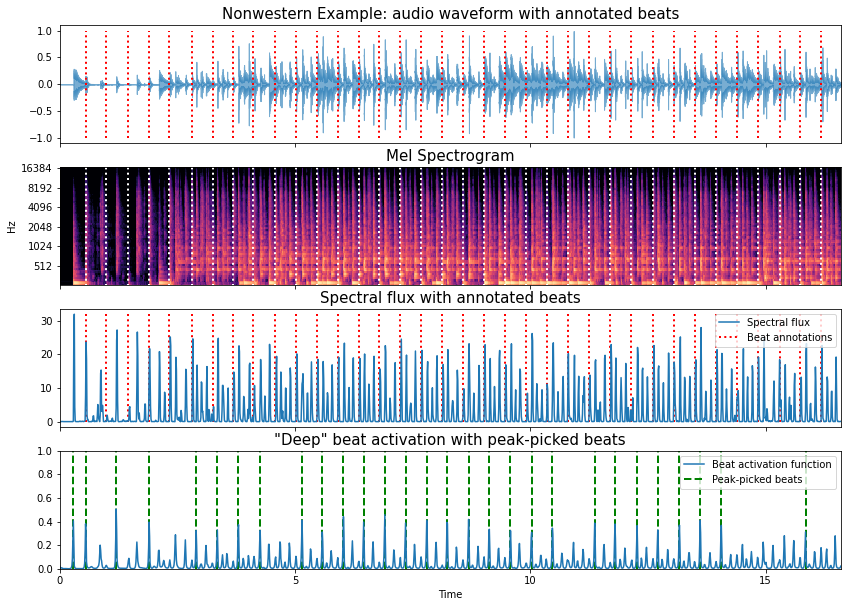

In [7]:
filename = '../assets/ch2_basics/audio/nonwestern_example'
# read audio and annotations
x, sr = librosa.load(filename+'.flac', sr = sr)
ref_beats = np.loadtxt(filename+'.beats')
ref_beats = ref_beats[:,0]

# make the mel spectrogram
S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)

# calculate the spectral flux function
spectral_flux = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sr,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)


# calculate the deep beat activation function
beat_act = beat_processor(x)

# and threshold it to get a crude estimate of the beats
est_beats = peakpicker(beat_act)

frame_time = librosa.frames_to_time(np.arange(len(spectral_flux)),
                                    sr=sr,
                                    hop_length=hop_length)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(14,10))

librosa.display.waveplot(x, sr=sr, alpha=0.6, ax=ax[0]); # this semi-colon surpresses the matplotlib stdout <matplotlib.zzz.zzz at 0x etc.>

ax[0].set_title('Nonwestern Example: audio waveform with annotated beats', fontsize=15)
ax[0].vlines(ref_beats, -1, 1, label='Beats', color='r', linestyle=':', linewidth=2)
ax[0].label_outer()

librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].vlines(ref_beats, 0, fmax, label='Beats', color='w', linestyle=':', linewidth=2)


ax[1].set_title('Mel Spectrogram', fontsize=15)
ax[1].label_outer()



ax[2].plot(frame_time, spectral_flux, label='Spectral flux')
ax[2].vlines(ref_beats, 0, spectral_flux.max(), label='Beat annotations', color='r', linestyle=':', linewidth=2)
ax[2].legend()
ax[2].set_title('Spectral flux with annotated beats', fontsize=15)


ax[3].plot(frame_time, beat_act,  label='Beat activation function')
ax[3].vlines(est_beats, 0, 1, label='Peak-picked beats', color='green', linestyle='--', linewidth=2)
ax[3].legend()
plt.xlabel('Time')
ax[3].set_title('"Deep" beat activation with peak-picked beats', fontsize=15)


ax[3].set(ylim=[0, 1])

ax[3].set(xlim=[0, len(x)/sr]);




In [9]:
print('Fmeasure:', round(mir_eval.beat.f_measure(ref_beats, est_beats), 3))

Fmeasure: 0.062


**ruh-roh!**

So, for the Candombe example, the "off the shelf" deep neural network approach 
combined with naïve peak-picking hasn't worked at all!
While the beat activation function has some strong-ish peaks they don't coincide with the annotated
beat locations as in the earlier example. 
Also, there are a lot of additional peaks present in the beat activation function,
suggesting that the network can't clearly disambiguate what should and shouldn't be a beat. 

As we move forward into the next stages of the tutorial, we can seek to understand:
* why this might be the case
* how deep models can be trained to produce very convincing outputs
* and, what to do when they don't (it's not game over!)